$\color{cyan}{\textbf{Assignment 3 - CNN for classification}}$

Trabalho realizado por:

    Pedro Ferreira Nº2018285801
    Telmo Cunha Nº 2018308321


$\color{cyan}{\textbf{Imports}}$

In [1]:
import os, os.path
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from PIL import Image
import torchvision.transforms as transforms
import torch
import math
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, recall_score, precision_score
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models
import torchsummary
from torch.utils import data
import pandas as pd
import seaborn as sn

c:\Users\pedro\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$\color{cyan}{\textbf{Get data for dataset}}$

In [2]:
label_type = "10"

In [3]:
separation = 10

folderPath = "Image Datasets/crop_part1"
files_paths = os.listdir(folderPath)

img = cv2.imread(os.path.join(folderPath ,files_paths[0]))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape
        
img_data = []
labels_origin = []

for filename in files_paths:
    img = cv2.imread(os.path.join(folderPath ,filename))
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    img_RGB = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_norm = cv2.normalize(img_RGB, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    x = filename.split("_")

    if label_type=="100":
        labels_origin.append(int(x[0]))
    if label_type=="10":
        labels_origin.append(math.floor((int(x[0])+1)/separation))
    if label_type=="gender":
        if len(x)<4:
            continue
        labels_origin.append(int(x[1]))

    img_data.append(img_norm)

img_data = np.array(img_data)
labels_origin = np.array(labels_origin)
print("Total labels: "+str(len(labels_origin)))
print("Total images: "+str(len(img_data)))

Total labels: 9780
Total images: 9780


In [4]:
labels = labels_origin
classes = np.unique(labels)
print("Classes:", classes)
for i in range(len(classes)):
    Classe_N = sum((labels==classes[i]).astype('int'))
    print("Class", classes[i] , "has" ,Classe_N, "samples.")

    if classes[i]>100:
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

    if Classe_N<300 and label_type=="10":
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

classes = np.unique(labels)
print(classes)
print("Total labels: "+str(len(labels)))
print("Total images: "+str(len(img_data)))

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class 0 has 2787 samples.
Class 1 has 1319 samples.
Class 2 has 1425 samples.
Class 3 has 1048 samples.
Class 4 has 712 samples.
Class 5 has 978 samples.
Class 6 has 670 samples.
Class 7 has 408 samples.
Class 8 has 318 samples.
Class 9 has 108 samples.
Class 10 has 5 samples.
Class 11 has 2 samples.
[0 1 2 3 4 5 6 7 8]
Total labels: 9665
Total images: 9665


In [5]:
target_names = []
c_class = np.unique(labels)
genders = ["Male","Female"]

if label_type=="100":
    for i in range(len(c_class)):
        target_names.append(str(c_class[i]))

if label_type=="10":
    dist = 10
    for i in range(len(np.unique(labels))):
            target_names.append(str(dist*c_class[i])+"-"+str(dist*c_class[i]+dist-1))

if label_type=="gender":
    for i in range(len(np.unique(labels))):
        target_names.append(genders[i])
print(target_names)

['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']



$\color{cyan}{\textbf{Define pytorch dataset class}}$


In [6]:
class Dataset (data.Dataset):
    def __init__ (self , images , labels):
        self.images = images
        self.labels = labels
        
    def __len__ (self):
        return len(self.images)

    def __getitem__ (self , index ):
        img = np.array(self.images[index])
        img = transforms.ToTensor()(img)
        label = self.labels[index]
        return img,label 
        

$\color{cyan}{\textbf{Data/Image inspection}}$

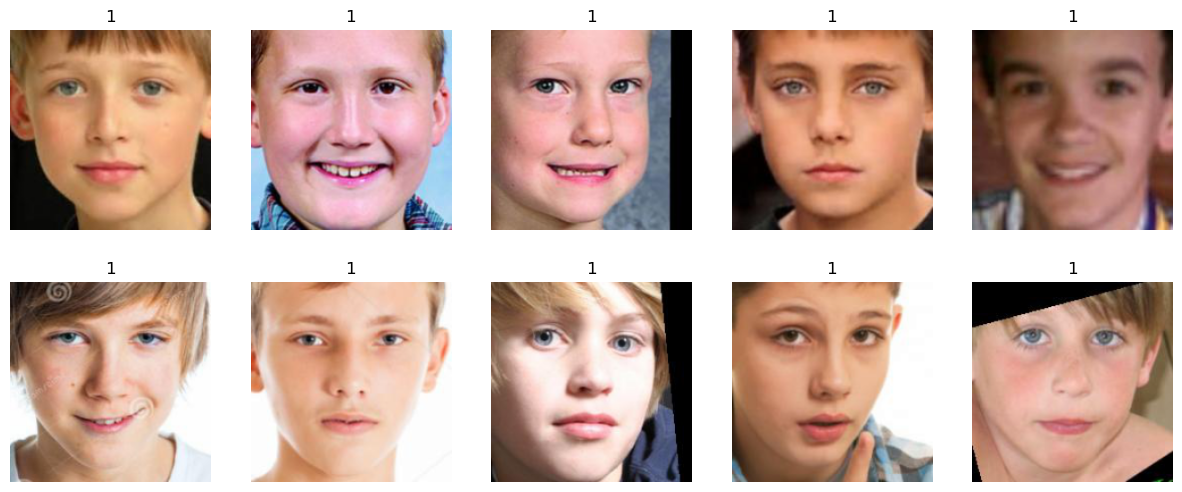

In [7]:
imgs = img_data

fig = plt.figure(figsize=(15, 6))

N_imgs = 0.001*len(labels)
if(N_imgs%2!=0):
    N_imgs += 1
N_imgs = int(N_imgs)

rows = 2
columns = int(N_imgs/rows)

for i in range(N_imgs):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.title(str(labels[i]))


$\color{cyan}{\textbf{Hyperparameters}}$

In [8]:
batch_size = 8
lr = 0.00001
num_epochs = 20

$\color{cyan}{\textbf{Data Splitiing/Loading}}$

In [9]:
if label_type=="100":
    labels = labels-1

dataset = Dataset(images = imgs,labels=labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will run on " + str(device))

test_ratio = 0.1
valid_ratio = 0.2

training_data, testing_data = torch.utils.data.random_split(dataset, [math.floor(len(dataset)*(1-test_ratio)),math.ceil(len(dataset)*test_ratio)])

num_train = len(training_data)
num_test = len(testing_data)
print("Number of images in original training set: " + str(num_train)) 
print("Number of images in original testing set: " + str(num_test))
indices = list(range(num_train))

split = int(np.floor(num_train * valid_ratio ))
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split]
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

training_loader = torch.utils.data.DataLoader(dataset = training_data, batch_size = batch_size, sampler = training_sampler)
valid_loader = torch.utils.data.DataLoader(dataset = training_data, batch_size = batch_size, sampler = valid_sampler)
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, batch_size = batch_size)


The model will run on cuda
Number of images in original training set: 8698
Number of images in original testing set: 967
Split Number: 1739
Number of training images: 6959
Number of validation images: 1739


$\color{cyan}{\textbf{Batch data inspection}}$

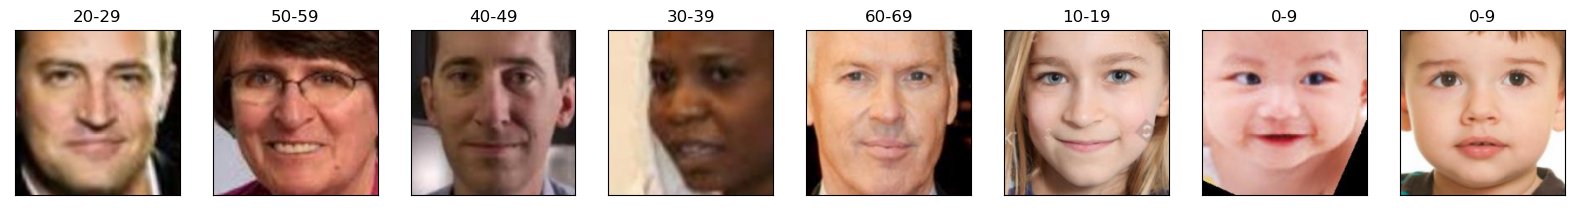

In [10]:
# Visualization of a whole batch
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

label_str = target_names
# Get images
dataiter = iter(training_loader)
images, labels = dataiter.__next__() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(20, 6))

# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    # Add a subplot for the image 
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    image = images[idx].permute(1, 2, 0)
    ax.imshow(image, cmap="gray")
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(label_str[labels[idx].item()])

$\color{cyan}{\textbf{Network architecture}}$

In [11]:
# ResNet18
cnn_model = models.resnet18(weights="IMAGENET1K_V1")

#for param in cnn_model.parameters():
# param.requires_grad = False
#cnn_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

cnn_model.fc = nn.Sequential(
    nn.Linear(512, 100),
    #nn.Softmax(dim=1)
)

cnn_model = cnn_model.to(device)

print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 224, 224), batch_size=batch_size)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]          36,864
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
       BasicBlock-11            [8, 64, 56, 56]               0
           Conv2d-12            [8, 64, 56, 56]          36,864
      BatchNorm2d-13            [8, 64, 56, 56]             128
             ReLU-14            [8, 

(tensor(11227812), tensor(11227812))

$\color{cyan}{\textbf{Model Training}}$

In [12]:
### Training

# Library imports
import torch.optim as optim

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2, verbose=True, factor = 0.05)

# Training
running_loss = 0.0
training_loss = 0.0

y_valid = list()
y_train = list()

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device

    images = images.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()
    

    # Check some statistics
    training_loss += loss.item()
    running_loss += loss.item()

  print("(Training Set) Epoch: " + str(epoch + 1) + " Loss: " + str(training_loss/(len(training_idx)/batch_size)))
  y_train.append(training_loss/(len(training_idx)/batch_size))
  training_loss = 0
  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images = valid_images.type(torch.FloatTensor)
      valid_labels = valid_labels.type(torch.LongTensor)
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/(len(valid_idx)/batch_size)) + " Acc: " + str(100*valid_correct/valid_total))

  # x e y para o plot da loss por epoch

  y_valid.append(valid_total_loss/(len(valid_idx)/batch_size))

  #scheduler.step()
  scheduler.step(valid_total_loss/len(valid_idx))


print("Training is completed!\n")



(Training Set) Epoch: 1 Loss: 2.254174662794356
(Validation Set) Epoch: 1 Loss: 1.392988135308764 Acc: 50.8338125359402
(Training Set) Epoch: 2 Loss: 1.1913793952424974
(Validation Set) Epoch: 2 Loss: 1.211757227358563 Acc: 54.629097182288675
(Training Set) Epoch: 3 Loss: 0.9835138046496523
(Validation Set) Epoch: 3 Loss: 1.1270548051084988 Acc: 56.411730879815984
(Training Set) Epoch: 4 Loss: 0.8309094087028147
(Validation Set) Epoch: 4 Loss: 1.114850148584323 Acc: 57.964347326049456
(Training Set) Epoch: 5 Loss: 0.69461164201774
(Validation Set) Epoch: 5 Loss: 1.1302298881186363 Acc: 56.469235192639445
(Training Set) Epoch: 6 Loss: 0.5601786232693542
(Validation Set) Epoch: 6 Loss: 1.113825439241441 Acc: 57.50431282346176
(Training Set) Epoch: 7 Loss: 0.44889329200607037
(Validation Set) Epoch: 7 Loss: 1.1022517323288306 Acc: 59.401955146636
(Training Set) Epoch: 8 Loss: 0.3370110153004191
(Validation Set) Epoch: 8 Loss: 1.1716000811679395 Acc: 57.216791259344454
(Training Set) Epoch

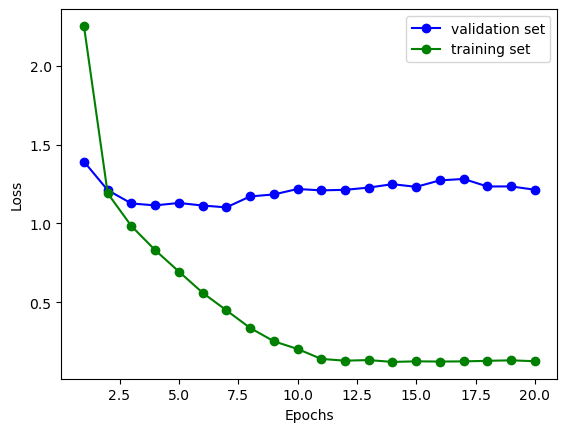

In [13]:
# plot  
x = list(range(1, num_epochs+1))
plt.plot(x, y_valid, 'bo-', label ='validation set')
plt.plot(x, y_train, 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

$\color{cyan}{\textbf{Test evaluation}}$

In [19]:
# Evaluate the CNN
num_classes = 9
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

Labels_total = np.zeros(len(testing_data))
Predictions_total = np.zeros(len(testing_data))

cnn_model.eval()

with torch.no_grad():
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data

    images = images.type(torch.FloatTensor)
    labels = labels.type(torch.LongTensor)
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    Labels_total[batch_size*batch_id : batch_size*(batch_id+1)] = labels.cpu().data.numpy()
    Predictions_total[batch_size*batch_id : batch_size*(batch_id+1)] = predicted.cpu().data.numpy()       

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    
    for i in range(len(images)):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1
        
    conf_matrix+=confusion_matrix(predicted.cpu(), labels.cpu(),labels=[x for x in range( num_classes )])

mean_class_acc = list()

# Show model's performance
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))
    mean_class_acc.append(100 * class_correct[i] / class_total[i])

mean_class_acc = np.sum(mean_class_acc) / num_classes
print("\nMean-Class Accuracy: " + str(mean_class_acc) + "%")

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)

# Macro metrics, mean of the metrics of each class
F1_score = f1_score(Labels_total, Predictions_total, average='macro')
Recall = recall_score(Labels_total, Predictions_total, average='macro')
Precision = precision_score(Labels_total, Predictions_total, average='macro')

print("\nMean F1 Score: " + str(F1_score*100))
print("\nMean Recall: " + str(Recall*100))
print("\nMean Precision: " + str(Precision*100))

Accuracy of  0 : 90 % in 281 Images
Accuracy of  1 : 76 % in 136 Images
Accuracy of  2 : 60 % in 150 Images
Accuracy of  3 : 29 % in 102 Images
Accuracy of  4 : 29 % in 65 Images
Accuracy of  5 : 43 % in 100 Images
Accuracy of  6 : 39 % in 74 Images
Accuracy of  7 : 41 % in 34 Images
Accuracy of  8 : 68 % in 25 Images

Mean-Class Accuracy: 53.02011508940544%

Confusion Matrix
[[253  18   4   1   1   0   1   0   0]
 [ 21 104  16   5   3   2   1   1   0]
 [  4  10  91  24   4   2   2   0   0]
 [  0   3  28  30  14   5   4   0   0]
 [  1   0   7  28  19  20   3   1   0]
 [  0   1   4  10  19  43  21   7   2]
 [  2   0   0   2   5  19  29   6   1]
 [  0   0   0   2   0   8  10  14   5]
 [  0   0   0   0   0   1   3   5  17]]

Mean F1 Score: 52.572266634420075

Mean Recall: 53.02011508940543

Mean Precision: 52.43897710150757


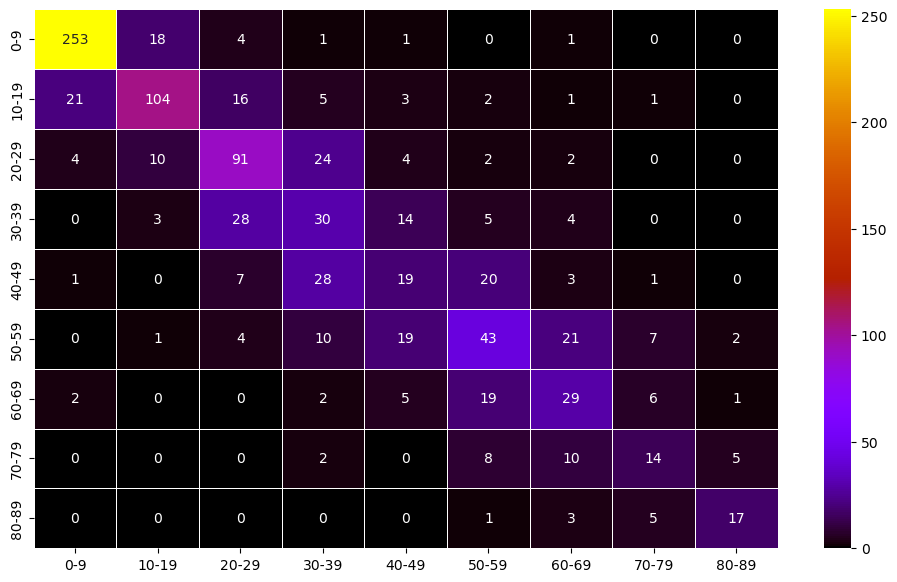

In [20]:
# Define all the classes to print in confusion matrix
classes = target_names

# Define a pandas dataframe with the data from the confusion matrix calculated above
df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

# Using seaborn heatmap to help visualize the confusion matrix
sn.heatmap(df_cm, annot=True, fmt='g', linewidth=.5, cmap="gnuplot")
plt.savefig('output.png')

$\color{cyan}{\textbf{Test predictions visualization}}$

In [21]:
# Function to convert a tensor to an image
def im_convert(tensor):  
  tensor = tensor.permute(1, 2, 0)
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image*255

  image = image.astype(int)
  
  return image

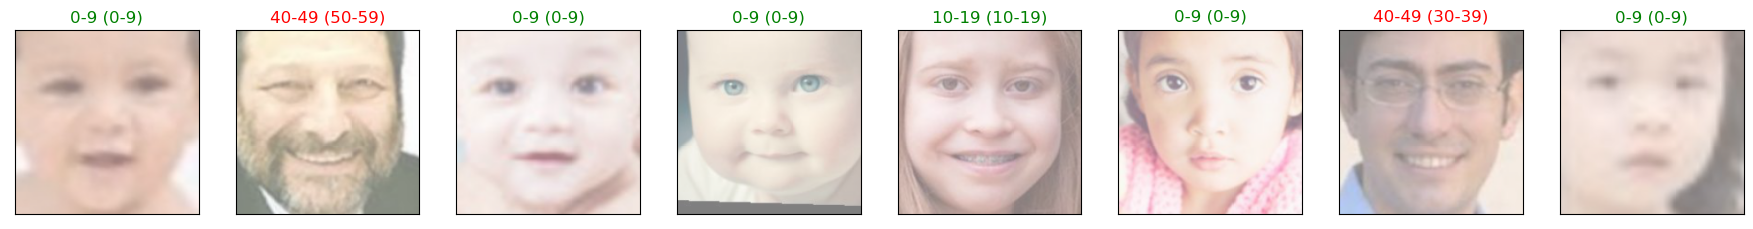

In [22]:
# Define all the classes, to see the string labels when printing the images
classes = target_names

# Use testing loader to get a batch of images
dataiter = iter(testing_loader)
images, labels = dataiter.__next__()

images = images.type(torch.FloatTensor)
labels = labels.type(torch.LongTensor)
images = images.to(device)
labels = labels.to(device)

output = cnn_model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(28, 6))

# Plot test images with predictions and labels in between parenthesis
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

$\color{cyan}{\textbf{Save/Load model}}$

In [ ]:
# If we need to save the model for later use
torch.save(cnn_model.state_dict(), "model_Resnet18")

In [ ]:
# If w want to load a past model
cnn_model.load_state_dict(torch.load("model_Resnet18", map_location="cuda:0"))

<All keys matched successfully>